# 1. Settings

## Important required libraries

In [71]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
%cd /content/drive/My\ Drive/Colab\ Notebooks

/content/drive/My Drive/Colab Notebooks


In [73]:
import utils

## Hyperparameter

In [74]:
batch_size = 16 #64 #1
learning_rate = 0.0001
epoch = 20

n_node = 1024 # customized last layer 의 노드 수. 64, 128, 256, 512, 1024
dropratio = 0.5 # 얼마나 드랍시킬지 inverse keepratio

imgsize = 256

# 2. Data Loader

## 트레이닝 데이터

In [75]:
img_dir = "instrument/train"
train_data = dset.ImageFolder(img_dir, transforms.Compose([
    transforms.CenterCrop(imgsize*2),
    transforms.RandomCrop(imgsize),
    transforms.RandomHorizontalFlip(),
    
    transforms.Resize(imgsize),
    transforms.ToTensor()
    ]))
print(train_data.__len__())

train_batch = data.DataLoader(train_data, batch_size = batch_size,
                             shuffle = True, num_workers = 2)

40


## 고정된 데이터 셋

In [76]:
# 2. Dev data
img_dir = "instrument/val"
dev_data = dset.ImageFolder(img_dir, transforms.Compose([
    transforms.CenterCrop(size = imgsize),
    transforms.Resize(imgsize),
    transforms.ToTensor()
    ]))
dev_batch = data.DataLoader(dev_data, batch_size=batch_size,
                           shuffle = False, num_workers=2)
# 3. Test data
img_dir = "instrument/test"
test_data = dset.ImageFolder(img_dir, transforms.Compose([
    transforms.CenterCrop(size = imgsize),
    transforms.Resize(imgsize),
    transforms.ToTensor()
]))
test_batch = data.DataLoader(test_data, batch_size=batch_size,
                           shuffle = False, num_workers=2)
nclass = len(train_data.classes)
print("# of classes: %d" %nclass)
print(train_data.classes)
print(train_data.class_to_idx)
print(train_data.__len__())

print("Training: %d, Dev: %d, Test: %d"
     %(train_data.__len__(), dev_data.__len__(), test_data.__len__())),

# of classes: 2
['guitar', 'piano']
{'guitar': 0, 'piano': 1}
40
Training: 40, Dev: 20, Test: 20


(None,)

In [77]:
print(train_data.classes)
print(dev_data.classes)
print(test_data.classes)

['guitar', 'piano']
['guitar', 'piano']
['guitar', 'piano']


# 3. Model

## 1) Pretrained VGG Model

In [78]:
vgg = models.vgg19(pretrained = True)

for name,module in vgg.named_children():
    print(name)
    
print(list(vgg.children())[0])
print(list(vgg.children())[-1])

features
avgpool
classifier
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(

In [79]:
print(list(vgg.children())[0][0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


## 2) Customized Fully Model

In [92]:
base_dim = 64
fsize = int(imgsize/32)

class MyVGG(nn.Module):
    def __init__(self):
        super(MyVGG, self).__init__()
        self.layer0 = nn.Sequential(*list(vgg.children())[0])
        
        self.layer1 = nn.Sequential(
            nn.Linear(8*base_dim * fsize * fsize, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
        
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
        
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, nclass),
        )
        #weight initialization
        for m in self.layer1.modules():
            #print(m)
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight.data) # RELU 일 때
                m.bias.data.fill_(0)
            if isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)
    def forward(self, x):
          # layer0의 사이즈를 무식하게 프린트하여 알아낼 수 있음.(batchsize, x, x, x)
          #print(x.size())
          out = self.layer0(x)
          out = out.view(out.size(0), -1)
          out = self.layer1(out)
          return out

## 3) Model on GPU

In [93]:
model = MyVGG().cuda()
#RuntimeError: cuda runtime error (100) : no CUDA-capable device is detected at /opt/conda/conda-bld/pytorch_1579022021485/work/aten/src/THC/THCGeneral.cpp:50
#여기서 위의 오류가 떠서 AWS에서 google colab으로 바꾸었다.

for params in model.layer0.parameters():
    params.required_grad = False
    
for params in model.layer1.parameters():
    params.required_grad = True

In [94]:
for name in model.children():
    print(name)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

# 4. Optimizer & Loss


In [95]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.layer1.parameters(), lr = learning_rate)

# 5. Train

In [97]:
import utils

total_time = 0
disp_step = 10

to_train = True
if (to_train == False):
    netname = './nets/inst_vgg19_10.pkl'
    model = torch.load(netname)
else:
    print("3 layer, n_node: %d, dropratio: %.2f" %(n_node, dropratio))
    model.eval()
    train_corr = utils.ComputeCorr(train_batch, model)
    dev_corr = utils.ComputeCorr(dev_batch, model)
    test_corr = utils.ComputeCorr(test_batch, model)
    print("Correct of train: %.2f, dev: %.2f, test: %.2f"
         %(train_corr, dev_corr, test_corr))
    model.train()
    
    netname = './nets/inst_vgg19'

    #graph 그리기
    x_epoch = []
    y_train_err = []
    y_dev_err = []
    y_test_err = []
    
    x_epoch.append(0)
    y_train_err.append(100.0-train_corr)
    y_dev_err.append(100.0-dev_corr)
    y_test_err.append(100.0-test_corr)
    
#     # 학습을 재시작한다면
#     netname = '../nets/media_pre_vgg19.pkl'
#     model = torch.load(netname)
#     #파라미터 학습 여부 결정
#     for params in model.layer0.parameters():
#         params.required_grad = False
#     for params in model.layer1.parameters():
#         params.required_grad = True
#     for i in range(34, epoch):
        
    # 재시작하지 않는다면
    for i in range(epoch):
        start_time = time.time()
        print("%d.." %i),
        for img, label in train_batch:
            img = Variable(img).cuda()
            label = Variable(label).cuda()
            
            optimizer.zero_grad()
            output = model(img)
            loss = loss_func(output, label)
            loss.backward()
            optimizer.step()
            
        end_time = time.time()
        duration = end_time - start_time
        total_time += duration
        if(i % disp_step == 0) or (i == epoch - 1):
            torch.save(model, netname+'_%d.pkl'%i, )
            print("\n[%d/%d] loss: %.3f, " %(i, epoch, (loss.cpu()).data.numpy())),
            
            model.eval()
            
            # train, dev, train accr
            train_corr = utils.ComputeCorr(train_batch, model)
            devtrain_corr = utils.ComputeCorr(dev_batch, model)
            test_corr = utils.ComputeCorr(test_batch, model)
            print("Correct of train: %.2f, dev: %.2f, test: %.2f, "
                 %(train_corr, dev_corr, test_corr)),
            model.train()
            print("time: %.2f sec.." %(total_time))
            
            #graph 그리기
            x_epoch.append(i+1)
            y_train_err.append(100.0-train_corr)
            y_dev_err.append(100.0-dev_corr)
            y_test_err.append(100.0-test_corr)
    print("Total time: %.2f sec" %total_time)

3 layer, n_node: 1024, dropratio: 0.50
Correct of train: 52.50, dev: 50.00, test: 50.00
0..

[0/20] loss: 0.528, 
Correct of train: 60.00, dev: 50.00, test: 60.00, 
time: 0.92 sec..
1..
2..
3..
4..
5..
6..
7..
8..
9..
10..

[10/20] loss: 0.072, 
Correct of train: 100.00, dev: 50.00, test: 95.00, 
time: 10.39 sec..
11..
12..
13..
14..
15..
16..
17..
18..
19..

[19/20] loss: 0.126, 
Correct of train: 100.00, dev: 50.00, test: 95.00, 
time: 18.78 sec..
Total time: 18.78 sec


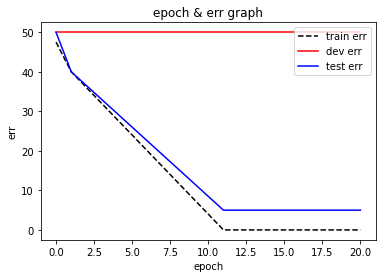

In [98]:
#epoch-err curve
if (to_train):
    plt.plot(x_epoch, y_train_err, color='black', label='train err', linestyle='--')
    plt.plot(x_epoch, y_dev_err, color='red', label='dev err')
    plt.plot(x_epoch, y_test_err, color='blue', label='test err')
    
    plt.xlabel('epoch')
    plt.ylabel('err')
    plt.title('epoch & err graph')
    plt.legend(loc="upper right")
    plt.show()

# 6. Evaluation for dev & test data

Normalized confusion matrix


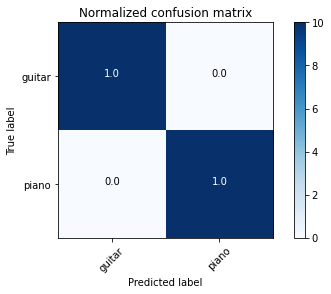

Confusion matrix, without normalization


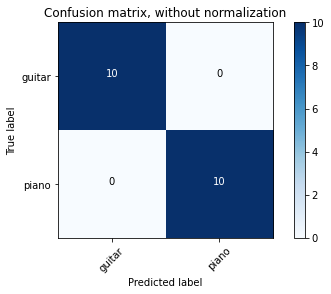

	 acc  |	 pre  |	 rec  |	 f1
 guitar: 1.00 |	 1.00 |	 1.00 |	 1.00
 piano: 1.00 |	 1.00 |	 1.00 |	 1.00
*accuracy: 1.00, precision: 1.00, recall: 1.00, *f1 score: 1.00
[AP]
guitar: 1.00
piano: 1.00

[mAP] 1.000
[miAP] 1.000


(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([0.96930712, 0.99993765, 0.996131  , 0.99668854, 0.99768037,
        0.99328536, 0.99628633, 0.98658723, 0.98901373, 0.99955618,
        0.71501446, 0.98275536, 0.99638945, 0.90605479, 0.76121789,
        0.91029364, 0.93018872, 0.83856457, 0.98691249, 0.97778851]))

In [101]:
model.eval()
utils.EvaluateClassifier(dev_batch, model, dev_data.classes, batch_size)

Normalized confusion matrix


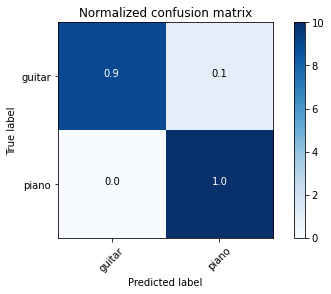

Confusion matrix, without normalization


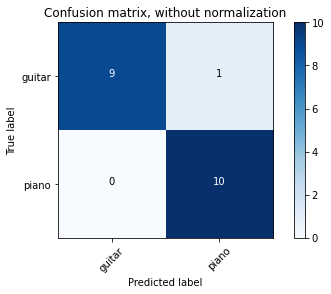

	 acc  |	 pre  |	 rec  |	 f1
 guitar: 0.95 |	 1.00 |	 0.90 |	 0.95
 piano: 0.95 |	 0.91 |	 1.00 |	 0.95
*accuracy: 0.95, precision: 0.95, recall: 0.95, *f1 score: 0.95
[AP]
guitar: 1.00
piano: 1.00

[mAP] 1.000
[miAP] 0.975


In [102]:
model.eval()
_, _,_ = utils.EvaluateClassifier(test_batch, model, test_data.classes, batch_size)

Category: guitar
 True predicted images/total guitar category: 10 / 10
Predicted probability:
[0.9693071  0.03069289]


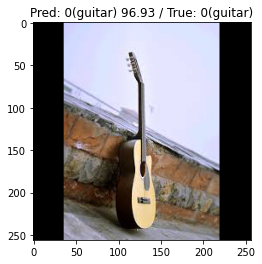

Predicted probability:
[9.9993765e-01 6.2358689e-05]


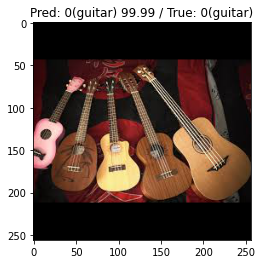

 False predicted images/total guitar category: 0 / 10
Category: piano
 True predicted images/total piano category: 10 / 10
Predicted probability:
[0.28498557 0.71501446]


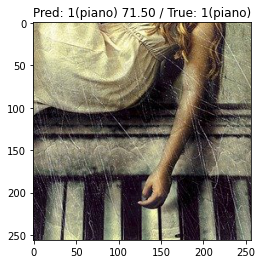

Predicted probability:
[0.01724464 0.98275536]


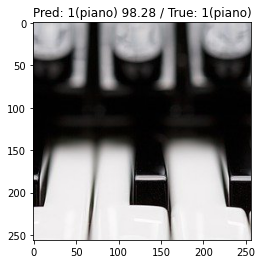

 False predicted images/total piano category: 0 / 10


In [103]:
utils.VisTFPred(dev_batch, model, test_data.classes, batch_size, i_n=2)